In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import style

#Use FiveThirtyEight graphics library in Seaborn to make plots look better
sns.set_theme(style=style.library["fivethirtyeight"], palette=None)

#Make Pandas show 25 columns since we'll be working with datasets that have 23 columns and I want to see all of them
pd.set_option('display.max_columns', 25)

# Introduction

Obesity remains a significant public health concern in the United States, contributing to a wide range of chronic health conditions and rising healthcare costs. This project seeks to examine the relationship between walkability and age-adjusted obesity rates, with the goal of understanding whether the built environment plays a meaningful role in influencing health outcomes at the population level.

The primary objective is to evaluate whether walkability — defined through factors such as (check the PDF) — is a statistically significant predictor of obesity prevalence. By isolating walkability as the independent variable of interest, the analysis will aim to determine if more walkable communities are associated with lower obesity rates.

To ensure a robust and well-controlled model, additional variables including median wage, jobs per household, and total population will be incorporated to account for socioeconomic and demographic influences. The project will use statistical modeling techniques, primarily linear regression, to assess the strength and significance of these relationships.

The analysis will draw on data from two main sources:

    The Smart Location Database (SLD), developed by the U.S. Environmental Protection Agency, which provides built environment and accessibility indicators at the census block group level. This contains that "NatWalkInd" score, is a composite score developed to assess how walkable an area is based on the following environmental characteristics:
        - Intersection Density (how many intersections there are which give pedestrians more route options)
        - Proximity to transit (how close a block is to public transit, supporting car-free mobility)
        - Employment Mix (the diversity of different employment types, like office vs retail vs industrial. High diversity means a higher ability to walk in the same area to both work, shop, and live without needing a car)
        - Employment and Household mix (measures how many people live and work in the same area, encouraging walking instead of driving)

    The PLACES: County Data project by the Centers for Disease Control and Prevention (CDC), which offers model-based estimates of health outcomes, including age-adjusted obesity rates, at the county level.

Ultimately, the goal is to provide insight into how urban planning and infrastructure might influence public health, and to offer data-driven evidence that could inform policies aimed at reducing obesity through environmental design.

# Data Pull

We will begin by pulling in the datasets. As previously described, those are the EPA's Smart Location Database and the CDC's places. A more descriptive introduction to these datasets are as follows:

    Smart Location Database (SLD) – Developed by the U.S. Environmental Protection Agency (EPA), the Smart Location Database provides a rich set of variables describing the built environment and accessibility characteristics at the census block group level. Key indicators include measures of walkability, land use diversity, employment density, housing characteristics, intersection density, and transportation options. These variables allow for a nuanced representation of how walkable or connected a community is, making this dataset especially valuable for studying the impact of the built environment on health-related outcomes.

    PLACES: County Data – Produced by the Centers for Disease Control and Prevention (CDC) in collaboration with the Robert Wood Johnson Foundation, the PLACES dataset offers model-based estimates of chronic disease risk factors, health outcomes, and healthcare access at the county level across the United States. Crucially for this project, it includes age-adjusted obesity prevalence estimates, which serve as the target variable in the analysis. These estimates are derived using Behavioral Risk Factor Surveillance System (BRFSS) data and small area estimation techniques, allowing for local-level health data where direct survey responses may be sparse.

I will begin by pulling these data from CSVs that were downloaded from the sources I've listed in the comments. I will then isolate variables that I believe will be important such as total land area, percentage of working population, and so on. I've listed some of these potential target variable definitions in the comments below. Further definitions will be listed in the links to the data glossaries.


In [4]:
#Data Glossary: https://www.epa.gov/system/files/documents/2023-10/epa_sld_3.0_technicaldocumentationuserguide_may2021_0.pdf
walkability = pd.read_csv(r'C:\Users\diviveiros\OneDrive - Microsoft\Documents\anaconda_projects\data\EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')
walkability = walkability.set_index('OBJECTID')

#Data Glossary: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2024-releas/i46a-9kgh/about_data
BMI_County = pd.read_csv(r'C:\Users\diviveiros\OneDrive - Microsoft\Documents\anaconda_projects\data\PLACES__County_Data__GIS_Friendly_Format___2024_release_20250413.csv')


In [5]:
column_list = [
 'STATEFP', #FIPS code for state
 'COUNTYFP', #Fips code for County
 'CBSA_Name', #Name of CBSA
 'Ac_Total', #Total Geometric area of CBG
 'Ac_Water', #Total water area
 'Ac_Land', #Total Land area
 'Ac_Unpr', #Total area that is not protected from development (not a park, etc) 
 'HH', #Occupied Housing Units (Households)
 'P_WrkAge', #Percent of pop that's working that's between 18 to 64
 'Pct_AO0', #Percent 0 car households
 'Pct_AO1', #Percent 1 car households
 'Pct_AO2p', #Percent 2 car households
 'R_PCTLOWWAGE', #Percent of low wage workers in a CBG (home location)
 'D1B', #Gross population density (people/acre) on unprotected land
 'D3A', #Road network density
 'D4A', #Distance from population centroid to nearest transit stop (meters)
 'D4B025', # Proportion of CBG employment within 1/4 mile of a transit stop 
 'D4B050', # Proportion of CBG employment within 1/2 mile of a transit stop
 'D4D', #Frequency of transit service per square mile
 'D4E',  #Frequency of transit service per capita
 'D5AE', #Working age population within 45 minutes of work 
 'D5BR', #Jobs within 45 minute transit commute
 'NatWalkInd'] #Walkbaility Index comprised of serveral weighted factors such as employment distance, transit quality, etc

In [6]:
walkability_clean = walkability[column_list].copy()

# Data Cleaning
Both the Walkability and the BMI datasets contain FIPS codes, which are used in datasets to uniquely identify geographic areas within the United States. It's a 5 digit code where the first 2 digits represents states and then the following three represent the county. 

As the SMART location database separates the FIPS into two columns (one for state, one for county), we will first create another column for this table to make it such that we can use the FIPS as a primary key to eventually join these two datasets


In [8]:
walkability_clean['CountyFIPS'] = walkability_clean['STATEFP'] * 1000 + walkability_clean['COUNTYFP']
walkability_clean.drop(['STATEFP', 'COUNTYFP'], axis=1, inplace=True)
walkability_clean['CountyFIPS']

OBJECTID
1         48113
2         48113
3         48113
4         48113
5         48113
          ...  
220736    78030
220737    78030
220738    78030
220739    78030
220740    78030
Name: CountyFIPS, Length: 220740, dtype: int64

In [9]:
walkability_clean.query('CountyFIPS == 78010')

,CBSA_Name,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd,CountyFIPS
OBJECTID,,,,,,,,,,,,,,,,,,,,,,
220652,NaN,804.804947,26.991474,777.813473,776.157295,316.0,0.0,0.0,0.0,0.0,0.0,0.930224,12.303820,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.333333,78010
220653,NaN,672.669705,0.000000,672.669705,672.669705,349.0,0.0,0.0,0.0,0.0,0.0,1.497020,7.296325,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.333333,78010
220654,NaN,1319.677333,504.018271,815.659062,357.295648,492.0,0.0,0.0,0.0,0.0,0.0,3.431332,9.070184,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.000000,78010
220655,NaN,301.471143,0.000000,301.471143,282.848053,479.0,0.0,0.0,0.0,0.0,0.0,4.857732,19.103277,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,5.666667,78010
220656,NaN,297.625772,0.600453,297.025320,297.025320,391.0,0.0,0.0,0.0,0.0,0.0,3.215214,14.044127,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.666667,78010
220657,NaN,918.131926,0.000000,918.131926,918.131926,405.0,0.0,0.0,0.0,0.0,0.0,1.226403,15.602650,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,4.333333,78010
220673,NaN,471.415650,0.000000,471.415650,471.415650,513.0,0.0,0.0,0.0,0.0,0.0,2.814926,16.248274,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,4.666667,78010
220674,NaN,448.265346,0.000000,448.265346,448.265346,473.0,0.0,0.0,0.0,0.0,0.0,2.563214,15.268133,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,4.666667,78010
220675,NaN,132.221480,0.000000,132.221480,132.221480,287.0,0.0,0.0,0.0,0.0,0.0,5.884067,25.017281,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,6.000000,78010


78010 is not a valid FIPS according to this list: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

1st step, remove all Values with CBSA_Name set to NaN. Then, verify that we don't have any FIPS higher than 56045 (highest FIP in the list).

We do see valid FIPS such as 72053 but those are from Puerto Rico where the data collected appears to be partly missing. As such, I am removing these as well.



In [11]:
#Drop any rows with "NaN" values in them
walkability_clean.dropna(subset=['CBSA_Name'], inplace=True)
walkability_clean

,CBSA_Name,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd,CountyFIPS
OBJECTID,,,,,,,,,,,,,,,,,,,,,,
1,"Dallas-Fort Worth-Arlington, TX",73.595028,0.000000,73.595028,73.595028,423.0,0.549,0.163121,0.092199,0.744681,0.240291,16.332625,23.534900,362.10,0.0,0.000000,37.654717,0.003602,303660,135362,14.000000,48113
2,"Dallas-Fort Worth-Arlington, TX",119.829909,0.000000,119.829909,119.214200,409.0,0.466,0.000000,0.410758,0.589242,0.192405,5.955666,22.893366,718.84,0.0,0.009516,23.126113,0.006099,272135,236885,10.833333,48113
3,"Dallas-Fort Worth-Arlington, TX",26.367053,0.000000,26.367053,26.367050,329.0,0.811,0.057751,0.434650,0.507599,0.293737,27.951553,14.210509,398.31,0.0,0.000000,72.818150,0.004071,288925,230587,8.333333,48113
4,"Dallas-Fort Worth-Arlington, TX",119.060687,0.000000,119.060687,119.060687,384.0,0.638,0.000000,0.111979,0.888021,0.139211,7.592767,32.178373,386.24,0.0,0.515377,35.853984,0.007378,298058,168433,15.666667,48113
5,"Dallas-Fort Worth-Arlington, TX",169.927211,0.000000,169.927211,148.742920,343.0,0.506,0.014577,0.195335,0.790087,0.157168,6.373413,22.058651,638.37,0.0,0.248922,25.121345,0.007036,238166,120826,10.166667,48113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220647,"San Juan-Bayamón-Caguas, PR",34.442281,0.000000,34.442281,34.442281,332.0,0.548,0.117470,0.475904,0.406627,0.000000,21.891698,30.054537,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,0,-99999,6.666667,72021
220648,"San Juan-Bayamón-Caguas, PR",27.042871,0.000000,27.042871,27.042871,291.0,0.524,0.151203,0.309278,0.539519,0.000000,31.801357,30.830335,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,0,-99999,6.333333,72021
220649,"San Juan-Bayamón-Caguas, PR",49.273470,0.000000,49.273470,49.273470,293.0,0.653,0.126280,0.447099,0.426621,0.000000,15.748840,27.114877,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,0,-99999,6.000000,72021


In [12]:
walkability_clean.query('CountyFIPS == 72053')

,CBSA_Name,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd,CountyFIPS
OBJECTID,,,,,,,,,,,,,,,,,,,,,,
218265,"San Juan-Bayamón-Caguas, PR",131.976851,4.204159,127.772692,127.623734,176.0,0.592,0.261364,0.488636,0.250000,0.0,3.377115,21.284366,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,6.000000,72053
218274,"San Juan-Bayamón-Caguas, PR",1255.550682,0.000000,1255.550682,1255.550682,676.0,0.642,0.130178,0.377219,0.492604,0.0,1.455138,10.971485,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.333333,72053
218275,"San Juan-Bayamón-Caguas, PR",252.659256,0.000000,252.659256,252.659256,702.0,0.564,0.180912,0.527066,0.292023,0.0,7.250872,12.591323,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,4.666667,72053
218276,"San Juan-Bayamón-Caguas, PR",16.948836,0.000000,16.948836,16.948836,208.0,0.502,0.548077,0.322115,0.129808,0.0,38.645722,26.556521,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,7.000000,72053
218277,"San Juan-Bayamón-Caguas, PR",181.244638,4.326721,176.917917,176.917917,237.0,0.498,0.434599,0.476793,0.088608,0.0,3.142700,21.862363,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,5.666667,72053
218278,"San Juan-Bayamón-Caguas, PR",160.840849,0.000000,160.840849,160.840849,540.0,0.523,0.192593,0.516667,0.290741,0.0,9.263816,27.440704,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,5.666667,72053
218283,"San Juan-Bayamón-Caguas, PR",144.356314,3.327202,141.029113,141.029113,216.0,0.476,0.212963,0.444444,0.342593,0.0,3.304282,10.914016,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,4.000000,72053
218348,"San Juan-Bayamón-Caguas, PR",28836.770650,28836.770650,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,1.000000,72053
218488,"San Juan-Bayamón-Caguas, PR",694.114278,164.691903,529.422375,527.086718,316.0,0.727,0.085443,0.588608,0.325949,0.0,1.056752,5.355120,-99999.0,0.0,0.0,-99999.0,-99999.0,0,-99999,3.000000,72053


In [13]:
#Get rows that have a FIPS value lesser than or equal to 56045
walkability_clean = walkability_clean.query('CountyFIPS <=56045')
walkability_clean

,CBSA_Name,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd,CountyFIPS
OBJECTID,,,,,,,,,,,,,,,,,,,,,,
1,"Dallas-Fort Worth-Arlington, TX",73.595028,0.000000,73.595028,73.595028,423.0,0.549,0.163121,0.092199,0.744681,0.240291,16.332625,23.534900,362.10,0.0,0.000000,37.654717,0.003602,303660,135362,14.000000,48113
2,"Dallas-Fort Worth-Arlington, TX",119.829909,0.000000,119.829909,119.214200,409.0,0.466,0.000000,0.410758,0.589242,0.192405,5.955666,22.893366,718.84,0.0,0.009516,23.126113,0.006099,272135,236885,10.833333,48113
3,"Dallas-Fort Worth-Arlington, TX",26.367053,0.000000,26.367053,26.367050,329.0,0.811,0.057751,0.434650,0.507599,0.293737,27.951553,14.210509,398.31,0.0,0.000000,72.818150,0.004071,288925,230587,8.333333,48113
4,"Dallas-Fort Worth-Arlington, TX",119.060687,0.000000,119.060687,119.060687,384.0,0.638,0.000000,0.111979,0.888021,0.139211,7.592767,32.178373,386.24,0.0,0.515377,35.853984,0.007378,298058,168433,15.666667,48113
5,"Dallas-Fort Worth-Arlington, TX",169.927211,0.000000,169.927211,148.742920,343.0,0.506,0.014577,0.195335,0.790087,0.157168,6.373413,22.058651,638.37,0.0,0.248922,25.121345,0.007036,238166,120826,10.166667,48113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217733,"Casper, WY",112.186365,0.000000,112.186365,112.186365,229.0,0.804,0.174672,0.401747,0.423581,0.238671,3.235687,27.315532,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,12385,-99999,12.833333,56025
217734,"Casper, WY",103.712565,0.000000,103.712565,98.471380,279.0,0.629,0.075269,0.344086,0.580645,0.282609,6.550127,30.309495,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,11814,-99999,11.666667,56025
217735,"Casper, WY",193.420737,0.000000,193.420737,185.670240,557.0,0.580,0.034111,0.342908,0.622980,0.221298,6.737752,23.012779,-99999.00,0.0,0.000000,-99999.000000,-99999.000000,11712,-99999,7.833333,56025


In [14]:
walkability_clean.isna().sum()

CBSA_Name       0
Ac_Total        0
Ac_Water        0
Ac_Land         0
Ac_Unpr         0
HH              0
P_WrkAge        0
Pct_AO0         0
Pct_AO1         0
Pct_AO2p        0
R_PCTLOWWAGE    0
D1B             0
D3A             0
D4A             0
D4B025          0
D4B050          0
D4D             0
D4E             0
D5AE            0
D5BR            0
NatWalkInd      0
CountyFIPS      0
dtype: int64

By dropping these datasets, we've verified that there are no NaNs in the dataset. Next, let's just make sure that each column has a value that isn't zero (or if it is zero, it makes sense)

In [16]:
#Next, let's check the number of rows in this dataset with columns that have zero values in them 
((walkability_clean == 0).mean()*100).round(2)

CBSA_Name        0.00
Ac_Total         0.00
Ac_Water        58.91
Ac_Land          0.25
Ac_Unpr          0.35
HH               0.71
P_WrkAge         0.50
Pct_AO0         23.11
Pct_AO1          1.11
Pct_AO2p         1.49
R_PCTLOWWAGE     0.37
D1B              0.49
D3A              0.26
D4A              1.54
D4B025          92.28
D4B050          88.06
D4D              0.00
D4E              0.14
D5AE             0.25
D5BR             0.00
NatWalkInd       0.00
CountyFIPS       0.00
dtype: float64

All of the relevant parameters appear to be good without any zeroes. The ones that potentially have zeroes make sense. To note some information is being revealed here already like there's not a lot of transit stops within a quarter or even half a mile of most workplaces for most of the population. 

With the dataset now having clean values, we need to address the difference in aggregation between the two datasets. The SMART dataset has information on Census blocks, while the PLACES dataset has information on counties. In order to validly compare these two datasets, we have to first consolidate in the SMART walkability dataset by county. This will require summing the total for parameters such as areas and households to get a total per county, while averaging other elements such as percent working age, percent that own a car, and the walkability index so that we have an overall average per county. 

In [19]:
walkability_county = walkability_clean.groupby('CountyFIPS').agg({
 'Ac_Total' : 'sum', 
 'Ac_Water' : 'sum',
 'Ac_Land' : 'sum', 
 'Ac_Unpr' : 'sum', 
 'HH' : 'sum',  
 'P_WrkAge' : 'mean', 
 'Pct_AO0'  : 'mean',
 'Pct_AO1'  : 'mean' , 
 'Pct_AO2p'  : 'mean', 
 'R_PCTLOWWAGE'  : 'mean', 
 'D1B' : 'mean', 
 'D3A' : 'mean', 
 'D4A': 'mean', 
 'D4B025' : 'mean', 
 'D4B050' : 'mean', 
 'D4D' : 'mean', 
 'D4E' : 'mean', 
 'D5AE': 'mean',
 'D5BR' : 'mean', 
 'NatWalkInd' : 'mean'})

walkability_county


,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd
CountyFIPS,,,,,,,,,,,,,,,,,,,,
1001,3.867879e+05,6352.190063,3.804357e+05,3.731588e+05,21115.0,0.598750,0.064802,0.272341,0.662856,0.230803,1.331898,6.720464,-99999.0,0.0,0.0,-99999.0,-99999.0,11970.687500,-99999.0,5.234375
1003,1.297424e+06,279959.572480,1.017464e+06,9.325742e+05,78622.0,0.552564,0.040567,0.324283,0.624511,0.242640,1.006401,6.515856,-99999.0,0.0,0.0,-99999.0,-99999.0,7550.265957,-99999.0,6.450355
1005,5.788771e+05,12484.285931,5.663928e+05,5.342933e+05,9186.0,0.583870,0.099287,0.341969,0.558744,0.263667,0.519424,4.188879,-99999.0,0.0,0.0,-99999.0,-99999.0,1636.608696,-99999.0,5.188406
1007,4.007393e+05,2372.676192,3.983666e+05,3.181298e+05,6840.0,0.564600,0.075590,0.275066,0.649344,0.217918,0.186857,3.070908,-99999.0,0.0,0.0,-99999.0,-99999.0,5876.200000,-99999.0,5.033333
1009,4.163930e+05,3710.321896,4.126827e+05,4.123054e+05,20600.0,0.569914,0.040744,0.264806,0.694450,0.204223,0.187021,3.180866,-99999.0,0.0,0.0,-99999.0,-99999.0,7521.285714,-99999.0,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,1.616889e+06,1973.422143,1.614916e+06,1.165595e+06,13159.0,0.564952,0.044161,0.270941,0.684898,0.261500,2.570623,11.988340,-99999.0,0.0,0.0,-99999.0,-99999.0,3172.190476,-99999.0,7.746032
56037,6.714197e+06,41075.495262,6.673122e+06,1.913513e+06,15871.0,0.612706,0.027847,0.206725,0.765428,0.218983,3.578549,11.636703,-99999.0,0.0,0.0,-99999.0,-99999.0,3964.676471,-99999.0,7.210784
56039,2.698987e+06,141060.711641,2.557926e+06,7.554800e+04,9158.0,0.670714,0.023459,0.303726,0.672816,0.316265,1.906767,7.056377,-99999.0,0.0,0.0,-99999.0,-99999.0,1628.714286,-99999.0,7.833333


In [20]:
walkability_county.sort_values('CountyFIPS')
walkability_county.describe()

,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd
count,1.840000e+03,1.840000e+03,1.840000e+03,1.840000e+03,1.840000e+03,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1.840000e+03,1840.000000
mean,6.357179e+05,4.203410e+04,5.936838e+05,4.455280e+05,6.118704e+04,0.581604,0.065414,0.305556,0.621786,0.249400,3.142715,9.619998,-86262.816009,0.003960,0.009936,-83912.058710,-83932.405950,22195.699403,-7.338986e+04,7.092067
std,9.815970e+05,1.452340e+05,9.596122e+05,4.593891e+05,1.468442e+05,0.032488,0.038352,0.054401,0.083320,0.031059,6.822310,5.361952,26396.042121,0.029738,0.054349,29793.947934,29739.905133,48500.323689,1.159646e+05,2.244969
min,1.309703e+03,7.907200e-03,1.309695e+03,1.287532e+03,3.300000e+01,0.229750,0.000000,0.096774,0.028029,0.132231,0.000238,0.241624,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,13.384615,-9.999900e+04,2.952381
25%,2.746828e+05,2.194155e+03,2.617123e+05,2.385810e+05,1.016950e+04,0.567131,0.044446,0.270322,0.574810,0.229697,0.749131,5.686321,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,4041.108385,-9.999900e+04,5.657760
50%,3.962106e+05,5.660763e+03,3.695860e+05,3.448618e+05,2.050850e+04,0.582489,0.059507,0.307737,0.625702,0.247440,1.790825,8.800130,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,8170.122016,-9.999900e+04,6.474172
75%,5.904880e+05,1.724567e+04,5.597916e+05,4.959500e+05,5.232300e+04,0.598832,0.078463,0.340783,0.677032,0.266269,3.617136,12.907929,-91595.188185,0.000000,0.000000,-87142.911857,-87143.003137,19511.310343,-9.121253e+04,7.810157
max,1.617647e+07,3.472663e+06,1.581669e+07,7.237125e+06,3.306109e+06,0.726409,0.702659,0.503323,0.886938,0.441379,173.476562,33.452718,541.969412,0.703104,0.895923,4959.857524,0.077182,680615.677549,3.046794e+06,15.957258


In [21]:
BMI_County

,StateAbbr,StateDesc,CountyName,CountyFIPS,TotalPopulation,TotalPop18plus,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,SHUTUTILITY_Crude95CI,SHUTUTILITY_AdjPrev,SHUTUTILITY_Adj95CI,LACKTRPT_CrudePrev,LACKTRPT_Crude95CI,LACKTRPT_AdjPrev,LACKTRPT_Adj95CI,EMOTIONSPT_CrudePrev,EMOTIONSPT_Crude95CI,EMOTIONSPT_AdjPrev,EMOTIONSPT_Adj95CI,Geolocation
0,SD,South Dakota,Yankton,46135,23373,18393,5.6,"( 4.9, 6.3)",7.7,"( 6.7, 8.6)",26.6,"(26.3, 26.9)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-97.3949292202413 43.0089434401039)
1,OK,Oklahoma,Haskell,40061,11641,8933,10.7,"( 9.5, 11.9)",14.1,"(12.4, 15.8)",37.6,"(37.3, 37.8)",...,"( 9.9, 12.9)",12.7,"(11.1, 14.4)",11.1,"(10.0, 12.2)",12.0,"(10.8, 13.1)",25.3,"(21.5, 29.3)",26.0,"(22.2, 30.1)",POINT (-95.116494065308 35.224815744206)
2,IL,Illinois,Lake,17097,709150,546991,10.1,"( 9.0, 11.3)",10.4,"( 9.2, 11.7)",24.2,"(23.2, 25.1)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.003802278105 42.3231861408737)
3,KS,Kansas,Atchison,20005,16108,12602,7.2,"( 6.3, 8.2)",9.5,"( 8.4, 10.7)",28.6,"(27.6, 29.6)",...,"( 6.7, 8.8)",9.0,"( 7.9, 10.2)",7.9,"( 7.2, 8.8)",8.3,"( 7.5, 9.2)",21.4,"(18.4, 24.7)",21.8,"(18.8, 25.2)",POINT (-95.3139519927859 39.5314729069169)
4,AK,Alaska,Anchorage,2020,287145,219637,7.7,"( 6.8, 8.6)",9.4,"( 8.3, 10.5)",21.6,"(21.2, 22.0)",...,"( 6.2, 8.1)",7.3,"( 6.4, 8.2)",8.4,"( 7.6, 9.2)",8.4,"( 7.6, 9.2)",25.4,"(22.8, 28.0)",25.4,"(22.9, 28.1)",POINT (-149.112545841578 61.150482370682)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,KY,Kentucky,Carlisle,21039,4720,3619,5.8,"( 5.1, 6.7)",8.6,"( 7.5, 9.9)",36.1,"(34.2, 38.0)",...,"( 7.7, 10.1)",10.0,"( 8.7, 11.4)",8.7,"( 7.9, 9.7)",9.7,"( 8.7, 10.6)",21.4,"(18.3, 24.9)",22.5,"(19.2, 26.0)",POINT (-88.9710130191677 36.8528730035718)
3140,MS,Mississippi,Copiah,28029,27719,21622,9.8,"( 8.6, 11.1)",13.8,"(12.2, 15.5)",35.7,"(34.0, 37.3)",...,"(12.2, 15.6)",15.9,"(14.1, 17.8)",14.1,"(12.9, 15.5)",15.4,"(14.1, 16.9)",33.9,"(29.8, 38.3)",35.3,"(31.2, 39.8)",POINT (-90.4488258448001 31.8691913743667)
3141,NY,New York,Queens,36081,2278029,1835438,7.2,"( 6.4, 7.9)",10.4,"( 9.4, 11.5)",19.7,"(19.3, 20.1)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.8194947909622 40.7034702188683)
3142,KS,Kansas,Rush,20165,2927,2321,6.5,"( 5.8, 7.3)",9.3,"( 8.3, 10.3)",32.6,"(31.0, 34.1)",...,"( 6.8, 8.9)",9.4,"( 8.1, 10.6)",7.5,"( 6.7, 8.3)",8.6,"( 7.7, 9.5)",20.4,"(17.3, 23.6)",21.9,"(18.6, 25.3)",POINT (-99.3086414479123 38.5227922552701)


In [22]:
BMI_County = BMI_County[ ['CountyName', 'CountyFIPS', 'TotalPopulation' , 'TotalPop18plus' , 'ACCESS2_AdjPrev', 'OBESITY_AdjPrev']]


BMI_County


,CountyName,CountyFIPS,TotalPopulation,TotalPop18plus,ACCESS2_AdjPrev,OBESITY_AdjPrev
0,Yankton,46135,23373,18393,7.7,35.3
1,Haskell,40061,11641,8933,14.1,43.7
2,Lake,17097,709150,546991,10.4,31.9
3,Atchison,20005,16108,12602,9.5,40.5
4,Anchorage,2020,287145,219637,9.4,29.6
...,...,...,...,...,...,...
3139,Carlisle,21039,4720,3619,8.6,40.8
3140,Copiah,28029,27719,21622,13.8,46.3
3141,Queens,36081,2278029,1835438,10.4,24.7
3142,Rush,20165,2927,2321,9.3,37.4


# Data Merge
With both datasets now clean and the parameters all set up, let's merge these datasets together. Then, we'll do another check for any potential NaNs to verify any potential issues with the merges.  

In [24]:
df_merged = pd.merge(BMI_County, walkability_county, on = 'CountyFIPS', how='left')

df_merged

,CountyName,CountyFIPS,TotalPopulation,TotalPop18plus,ACCESS2_AdjPrev,OBESITY_AdjPrev,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,HH,P_WrkAge,...,Pct_AO2p,R_PCTLOWWAGE,D1B,D3A,D4A,D4B025,D4B050,D4D,D4E,D5AE,D5BR,NatWalkInd
0,Yankton,46135,23373,18393,7.7,35.3,3.406398e+05,7085.991566,3.335538e+05,330309.699024,9359.0,0.597368,...,0.650248,0.283900,2.920937,11.636560,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,486.736842,-9.999900e+04,6.956140
1,Haskell,40061,11641,8933,14.1,43.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lake,17097,709150,546991,10.4,31.9,8.757111e+05,591621.333644,2.840898e+05,241526.881139,244672.0,0.595836,...,0.674449,0.216734,6.419509,16.165669,-49957.227239,0.028658,0.102964,-34817.379576,-34825.520560,99963.713930,-2.190198e+04,10.221393
3,Atchison,20005,16108,12602,9.5,40.5,2.776385e+05,1692.907304,2.759456e+05,275764.410504,5980.0,0.563375,...,0.622546,0.295892,2.494191,10.002338,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,5227.750000,-9.999900e+04,6.104167
4,Anchorage,2020,287145,219637,9.4,29.6,1.244164e+06,151835.954586,1.092328e+06,304130.558418,106524.0,0.650869,...,0.601760,0.283217,28.776811,18.139308,-27663.394065,0.000000,0.000000,-25201.601208,-25233.385142,235.299065,1.411677e+04,10.922897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Carlisle,21039,4720,3619,8.6,40.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3140,Copiah,28029,27719,21622,13.8,46.3,4.988464e+05,1394.825138,4.974515e+05,482105.017170,9623.0,0.574542,...,0.601985,0.260571,0.530988,4.527530,-99999.000000,0.000000,0.000000,-99999.000000,-99999.000000,6190.208333,-9.999900e+04,4.673611
3141,Queens,36081,2278029,1835438,10.4,24.7,1.139377e+05,44321.071487,6.961659e+04,60853.154198,779234.0,0.612726,...,0.254380,0.207407,64.556571,29.124287,-2378.926867,0.246472,0.504598,-751.960224,-2577.243154,680615.677549,1.366672e+06,14.113498
3142,Rush,20165,2927,2321,9.3,37.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After merging these datasets, we can see that there are 1312 NaN values, this is accounted by there being counties that were accounted for in the Obesity dataset than in the Walkability datset. In a future experiment, it would be useful to have these 1312 counties accounted for in the walkability dataset as well to have even more data points to pull from. 

In [26]:
df_merged.isna().sum()



CountyName            0
CountyFIPS            0
TotalPopulation       0
TotalPop18plus        0
ACCESS2_AdjPrev       0
OBESITY_AdjPrev       0
Ac_Total           1312
Ac_Water           1312
Ac_Land            1312
Ac_Unpr            1312
HH                 1312
P_WrkAge           1312
Pct_AO0            1312
Pct_AO1            1312
Pct_AO2p           1312
R_PCTLOWWAGE       1312
D1B                1312
D3A                1312
D4A                1312
D4B025             1312
D4B050             1312
D4D                1312
D4E                1312
D5AE               1312
D5BR               1312
NatWalkInd         1312
dtype: int64

In [27]:
df_merged = df_merged.dropna()

In [28]:
df_merged.columns

Index(['CountyName', 'CountyFIPS', 'TotalPopulation', 'TotalPop18plus',
       'ACCESS2_AdjPrev', 'OBESITY_AdjPrev', 'Ac_Total', 'Ac_Water', 'Ac_Land',
       'Ac_Unpr', 'HH', 'P_WrkAge', 'Pct_AO0', 'Pct_AO1', 'Pct_AO2p',
       'R_PCTLOWWAGE', 'D1B', 'D3A', 'D4A', 'D4B025', 'D4B050', 'D4D', 'D4E',
       'D5AE', 'D5BR', 'NatWalkInd'],
      dtype='object')

# Data Visualization

With the datasets being verified as clean and merged, let us first do some basic data visualization to see general trends and verify if our hypothesis makes sense. This also gives us a chance to verify if the counties that we have in our dataset are representative of trends that we see in the United States as a whole. Afterwards, we can begin regression and analysis.

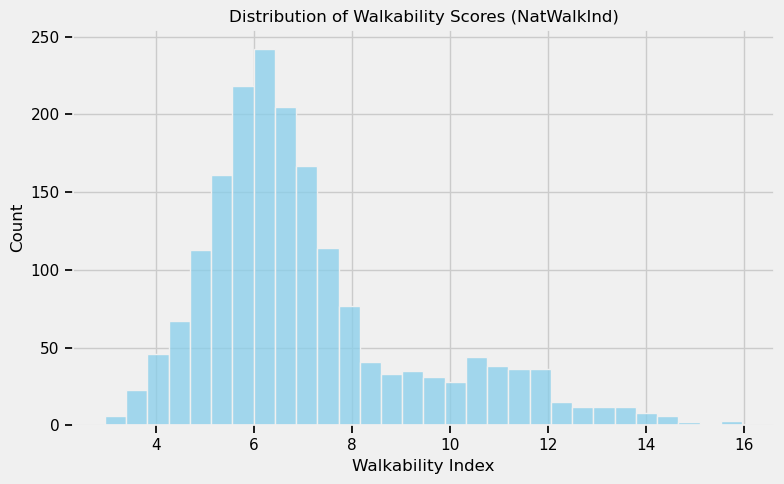

In [43]:

#Generate basic plot
plt.figure(figsize=(8, 5))

#Insert Histplot and add data from merged data set
sns.histplot(df_merged['NatWalkInd'], bins=30, kde=False, color='skyblue')

#Add title, labels, and render plot
plt.title('Distribution of Walkability Scores (NatWalkInd)')
plt.xlabel('Walkability Index')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The distribution of walkability scores per county  appears to be right-skewed. This means that there are more values clustered on the left side of the histogram, with a tail extending towards higher walkability index values on the right. Right-skewness indicates that most of the data points have lower walkability scores, while fewer data points have higher walkability scores.

The mode for county's overall walkability index appears to be around 6, which is quite low. For context, the EPA's NatWalkInd variable that we're using considers anything lower than a 10.5 as "Below Average Walkable", with values less than 5.75 as "least walkable". This is according to this source: https://www.epa.gov/sites/default/files/2021-06/documents/national_walkability_index_methodology_and_user_guide_june2021.pdf. This demonstrates quite how poorly walkability in general is in most of the United States, which is consistent with the overall analysis of the EPA's ratings in that documentation.



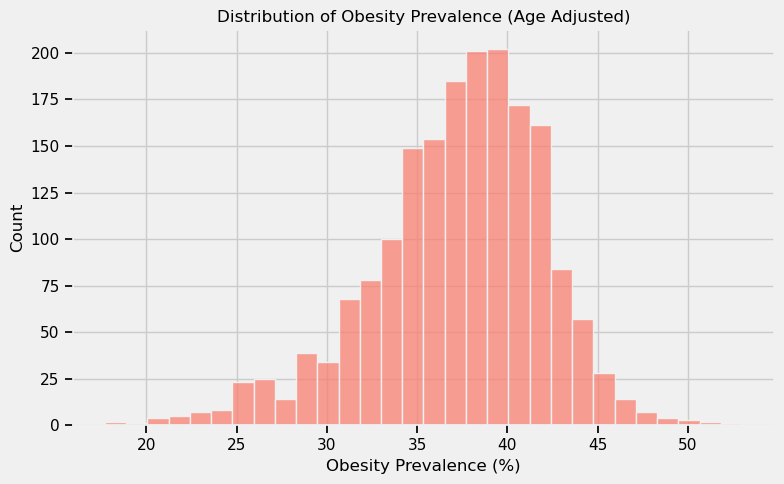

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(df_merged['OBESITY_AdjPrev'], bins=30, kde=False, color='salmon')
plt.title('Distribution of Obesity Prevalence (Age Adjusted)')
plt.xlabel('Obesity Prevalence (%)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

From the graph above, we can see that the distribution is overall left-skewed, showcasing how the distribution has an overall tendency to have more counties above 35% obesity prevalence overall. The mode for obesity in counties appears to be at around 40%. This matches CDC data (https://www.cdc.gov/obesity/adult-obesity-facts/index.html) stating that "The prevalence of obesity among U.S. adults 20 and over was 41.9% during 2017–March 2020.". As such, this county data should be well representative of overall health trends in the United States, from an age-adjusted obesity standpoint

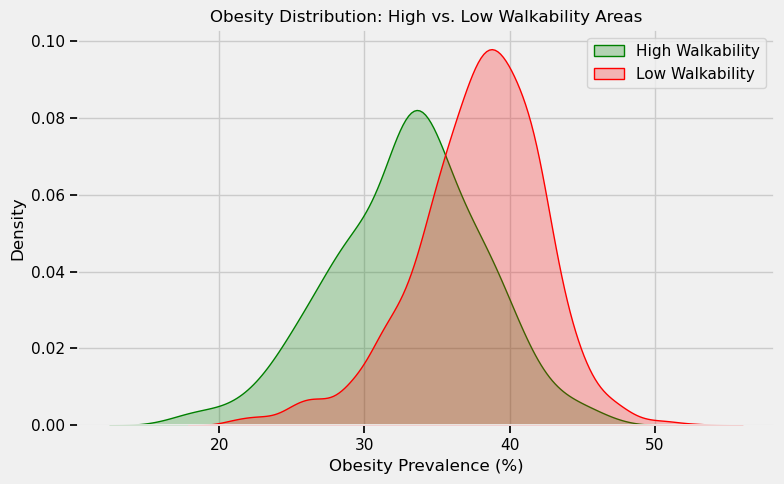

In [60]:
# Define high and low walkability areas
threshold = df_merged['NatWalkInd'].median()
high_walk = df_merged[df_merged['NatWalkInd'] > 10.5]
low_walk = df_merged[df_merged['NatWalkInd'] <= 10.5]

plt.figure(figsize=(8, 5))
sns.kdeplot(high_walk['OBESITY_AdjPrev'], label='High Walkability', fill=True, color='green')
sns.kdeplot(low_walk['OBESITY_AdjPrev'], label='Low Walkability', fill=True, color='red')
plt.title('Obesity Distribution: High vs. Low Walkability Areas')
plt.xlabel('Obesity Prevalence (%)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

The graph above was calculated by taking counties where the National Walking Index is defined as being "Above Average Walkable" or higher, which according to the EPA is a score of 10.51 and above. We then separated the dataframe into higher than 10.5 or lower than 10.5 to compare Obesity distribution.

What we see is a definite difference in obesity prevalence from high walkability to low walkability counties. The high walkability counties definitively show a slight right-skewed distribution when compared to the low walkbility's left-skew, with an overall mean that's lower as well. This certainly gives our hypothesis credibility that higher walkability areas generally lead to better Obesity outcomes. Of course, we should also try to isolate other cofounding variables such as general wealth (as counties with cities will be overall wealthier and more walkable, leading to lower obesity anyways), before coming to any overall conclusions.  

# Regression & Analysis

Now that the datasets are merged and we've deduced that we're on a conclusive path, we can begin doing some regression and do some analysis. 

I am going to set up two regressions. The first one will just be a simple regression that checks the age-adjusted obesity rate to the independent variable that we're measuring: NatWalkInd. 

Then, I will set up a regression with all of the independent variables that I pulled and believed would be relevant. These will assist the regression's accuracy by accounting for larger portions of the model that would account for obesity, and therefore also give us a more accurate notion of how much of the walkability index actually impacts obesity. 

During this process, I eliminated a lot of variables that causing multi-collinearity by using a Variance Inflation Factor (VIF) calculation. I then kept the features that were lowly correlated with each other, thereby keeping one of the conditions for a proper linear regression in check: that of no collinearity. 

In [66]:
#Separating Target variable from Paramater variables, just one independent variable for this one which is the one we're measuring: NatWalkInd

X_simple = df_merged['NatWalkInd']
X_simple = sm.add_constant(X_simple)


#Then, I'll set up another regression with low-collinearity parameters
X = df_merged[[
       'ACCESS2_AdjPrev', 'TotalPopulation','Ac_Total', 'Ac_Unpr', 'Pct_AO0',
       'R_PCTLOWWAGE',
       'NatWalkInd']]
X = sm.add_constant(X)

y = df_merged['OBESITY_AdjPrev']


#Check for Multicollinearity 

#calculate VIF for each predictor variable 
vif_df = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#view VIF for each predictor variable 
print(vif_df)

[87.10101235258594, 1.0962692524146715, 1.4485389142271945, 3.0938918126995945, 3.134081320543682, 1.202383692927616, 1.1248511878335845, 1.4856175383152028]


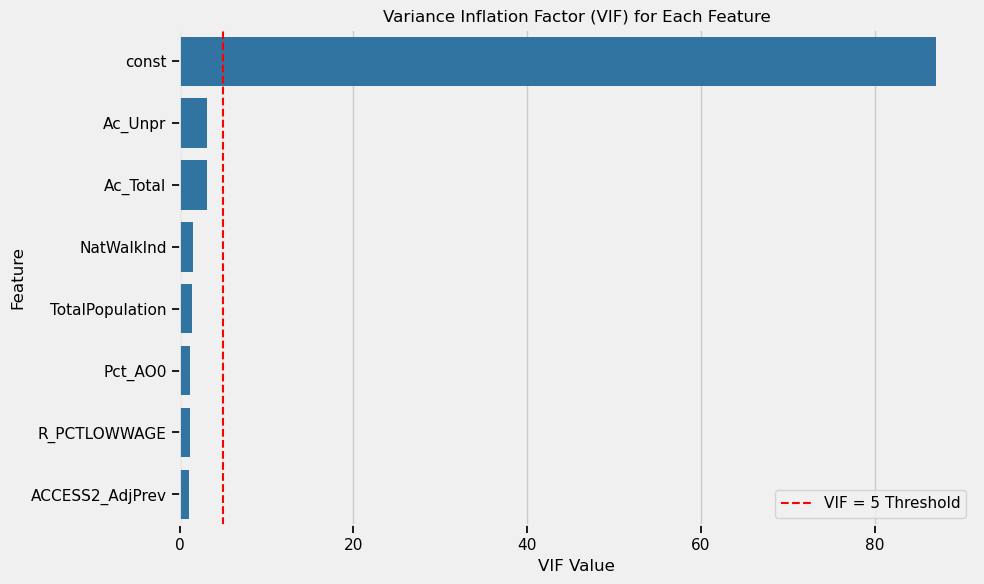

In [82]:
# Creating a DataFrame for easier plotting
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': vif_df
})

# Sorting by VIF
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data, x='VIF', y='Feature')
plt.title('Variance Inflation Factor (VIF) for Each Feature')
plt.xlabel('VIF Value')
plt.ylabel('Feature')
plt.axvline(x=5, color='red', linestyle='--', label='VIF = 5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
#Run Model

model_simple = sm.OLS(y, X_simple).fit()

print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:        OBESITY_AdjPrev   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     472.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.59e-93
Time:                        16:46:58   Log-Likelihood:                -5261.8
No. Observations:                1832   AIC:                         1.053e+04
Df Residuals:                    1830   BIC:                         1.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.1257      0.331    133.242      0.0

This simple model already tells us quite a lot: 
 - Walkability is significantly associated with lower obesity rates — even in a simple model with just one predictor.
 - Baed on the R² of ~20%, my model explains about 20.5% of the variance in obesity rates. We'll definitely want to explore additional variables to try and raise the R², but it's certainly a reasonable start for measuring a target with such complex causes such as Obesity.

Let's go ahead and add some of the independent variables we found were not collinear to get a better, more accurate model that also gives us a better sense of how much NatWalkInd impacts obesity. 

In this regression with additional variables, we added several controls that I believe are important. Here is the list of the variables that I added, what they represent, and how they're significant in this model:

| **Variable**         | **Description / Likely Meaning**                            | **Why It's Important as a Control** |
|----------------------|--------------------------------------------------------------|--------------------------------------|
| `ACCESS2_AdjPrev`    | % of adults without health insurance                         | Lack of healthcare access may increase obesity risk due to limited preventative care or treatment. Controls for disparities in healthcare access. |
| `TotalPopulation`    | Total county population                                       | Captures population size as a proxy for urban vs. rural context. Urban areas may have better walkability infrastructure. |
| `Ac_Total`           | Total job accessibility (within a certain distance)          | Reflects regional economic activity and development. Controls for access to employment opportunities. |
| `Ac_Unpr`            | Access to unprotected or unstable jobs                       | Accounts for job quality and economic vulnerability, which can affect health behaviors. |
| `Pct_AO0`            | Demographic share (e.g., % of population in a group)         | Adjusts for demographic variation in obesity risk (e.g., age, race/ethnicity). Clarify exact definition. |
| `R_PCTLOWWAGE`       | % of workers earning low wages                               | Controls for income-related disparities that affect diet, activity, and healthcare access. |


By including these variables, I'm confident that we can reduce omitted variable bias and allow the model to isolate the true effect of walkability. We're doing this by accounting for the socioeconomic elements that can impact obesity rates, thereby improving how much variance the model can account for and increase confidence that the observed relationship between walkability and obesity is not due to confounding.


In [86]:
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        OBESITY_AdjPrev   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     164.9
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          4.65e-189
Time:                        16:47:01   Log-Likelihood:                -5022.9
No. Observations:                1832   AIC:                         1.006e+04
Df Residuals:                    1824   BIC:                         1.011e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              33.3016      0.820     

Having run this model, we now see definite improvements. Our R-squared is 0.388 with an adjusted R-squared of 0.385. Our model is explaining around 38.5% of the variance in obesity rates, which is a big improvement from 20.5% in the univariate model!

# Conclusion

To summarize: in this analysis, NatWalkInd is used to investigate how neighborhood walkability relates to age-adjusted obesity prevalence at the county level. The regression results reveal a statistically significant and negative relationship between the walkability index and obesity rates — even after controlling for key socioeconomic and access-related variables. 

With a very high t-score of -18.138, our P-value is extremely tiny, and certainly below our 0.05 threshold. As such, we reject the null hypothesis that NatWalkInd has no effect of Obesity. Specifically, the coefficient for NatWalkInd is -0.8663, which means that for every 1-point increase in the walkability index, the model predicts a 0.87 percentage point decrease in the obesity rate (on average, holding all other variables constant). This suggests that more walkable environments are associated with measurably lower obesity prevalence, potentially due to increased opportunities for physical activity, active transportation, and easier access to health-supportive resources. These findings reinforce the idea that urban design and land use planning can have a meaningful impact on public health outcomes like obesity.

In a country that has a large dependency on road infrastructure at the detriment of having spaces that are easy for people to walk to, it is important to take this data into account in order to educate our policy-makers towards making decisions that can highly improve our health outcomes, particularly for those who are in less priviledged areas. 

At the same time, the R-squared value also tells us that there are definitely many other factors that impact obesity, and that also has to be taken into account when making policy decisions. Walkability certainly appears to have an impact according to this model, but there have to be policy pushes in several other areas as well in order to make meaningful improvements in the outcome of people's future health outcomes

In order to improve these results, I would like to:

- Have population data that was Zip Code specific instead of county specific. Even within a county, there can be large variations in walkability and wealth, therefore even obesity can vary a large amount from area to area within a county. Having more granular area data would improve our confidence in these results by quite a bit.
- Collect more independent variables that would help us increase our R-squared
- Explore non-linear models or interaction effects

